# Data and Libraries

In [26]:
import pandas as pd
import unicodedata 
import time
import nltk
import re 
import warnings
from tqdm import tqdm
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
from string import digits
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")
import sklearn.model_selection as sms

DATA_PATH = "defi-ia-insa-toulouse"
train_df = pd.read_json(DATA_PATH+"/train.json")
test_df = pd.read_json(DATA_PATH+"/test.json")
train_label = pd.read_csv(DATA_PATH+"/train_label.csv")
label_metier= pd.read_csv(DATA_PATH+"/categories_string.csv")
print("Taille des données train_df : %d lignes" %train_df.shape[0])
print("Taille des données train_label : %d lignes" %train_label.shape[0])
print("Taille des données test : %d lignes" %test_df.shape[0])
print("Taille des labels métiers : %d lignes" %label_metier.shape[0])

Taille des données train_df : 217197 lignes
Taille des données train_label : 217197 lignes
Taille des données test : 54300 lignes
Taille des labels métiers : 28 lignes


In [27]:
label_metier.rename(columns={"1" : "Category"}, inplace=True)

In [28]:
label_metier.head(5)

,0,Category
0,pastor,0
1,model,1
2,yoga_teacher,2
3,teacher,3
4,personal_trainer,4


In [29]:
train_df.head(5)

,Id,description,gender
0,0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,1,He is a member of the AICPA and WICPA. Brent ...,M
2,2,Dr. Aster has held teaching and research posi...,M
4,3,He runs a boutique design studio attending cl...,M
5,4,"He focuses on cloud security, identity and ac...",M


In [30]:
test_df.head(5)

,Id,description,gender
3,0,She currently works on CNN’s newest primetime...,F
6,1,Lavalette’s photographs have been shown widel...,M
11,2,Along with his academic and professional deve...,M
17,3,She obtained her Ph.D. in Islamic Studies at ...,F
18,4,She studies issues of women and Islam and has...,F


In [31]:
train_label.head(5)

,Id,Category
0,0,19
1,1,9
2,2,19
3,3,24
4,4,24


In [32]:
label_string=pd.merge(train_label,label_metier, on=['Category'])

On a merge les deux dataframe afin de mieux pouvoir visualiser les métiers en surreprésentation.

In [33]:
data_count = label_string["0"].value_counts()

fig = go.Figure()
fig.add_trace(go.Bar(x=data_count.index,
                y=data_count.values,
                marker_color='rgb(55, 83, 109)'
                ))

fig.update_layout(
    title='Distribution des description dans les catégories',
    xaxis_tickfont_size=12,
    xaxis_tickangle=70,
    yaxis=dict(
        title='Nombre de descriptions',
        titlefont_size=16,
        tickfont_size=14,
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

Faut équilibrer classe et genre métier.

On peut remarquer une grande disparité dans la représentation des catégories.

In [34]:
desc_metier=pd.merge(label_string,train_df, on=['Id'])

In [35]:
vocabulary_size = {metier : len(set(" ".join(desc_metier[desc_metier["0"]==metier]["description"].values).split(" "))) for metier in set(desc_metier["0"].values)}

fig = go.Figure()
fig.add_trace(go.Bar(x=data_count.index,
                y=[vocabulary_size[c] for c in data_count.index],
                marker_color='rgb(55, 83, 109)'
                ))

fig.update_layout(
    title='Size of vocabulary per work',
    xaxis_tickfont_size=12,
    xaxis_tickangle=70,
    yaxis=dict(
        title='Size of vocabulary',
        titlefont_size=16,
        tickfont_size=14,
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

# Cleaning

The only cleaning transformation applied here is that we `lower` the data so that all words are lower case. 
Hence `research`and `Research` will be considered as similar word.

You might want to look at other cleaning step such that removing stopwords, stemming words, etc.

In [36]:
i = 47
description = train_df.description.values[i]
print("Original Description : " + description)

Original Description :  Dr. Harr is a licensed clinical social worker with several years of practice and teaching experience both in the United States and internationally. She has conducted research and published in the areas of family, mental health, compassion fatigue, and interdisciplinary relationships.


In [37]:
digits_list = digits
class CleanText:

    def __init__(self):

        english_stopwords = nltk.corpus.stopwords.words('english')
        self.stopwords = [self.remove_accent(sw) for sw in english_stopwords]

        self.stemmer = nltk.stem.SnowballStemmer('english')

    @staticmethod
    def remove_html_code(txt):
        txt = BeautifulSoup(txt, "html.parser", from_encoding='utf-8').get_text()
        return txt

    @staticmethod
    def convert_text_to_lower_case(txt):
        return txt.lower()

    @staticmethod
    def remove_accent(txt):
        return unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")

    @staticmethod
    def remove_non_letters(txt):
        return re.sub('[^a-z_]', ' ', txt)

    def remove_stopwords(self, txt):
        return [w for w in txt.split() if (w not in self.stopwords)]

    def get_stem(self, tokens):
        return [self.stemmer.stem(token) for token in tokens]

In [38]:
c=CleanText()
def apply_all_transformation(description):
    description = c.remove_html_code(description)
    description = c.convert_text_to_lower_case(description)
    description = c.remove_accent(description)
    description = c.remove_non_letters(description)
    tokens = c.remove_stopwords(description)
    tokens = c.get_stem(tokens)
    return tokens

In [39]:
# %load solution/clean_dataframe_2.py
def clean_df_column(df,column_name, clean_column_name) :
    df[clean_column_name]=[" ".join(apply_all_transformation(x)) for x in tqdm(df[column_name].values)]

In [40]:
clean_df_column(train_df, "description", "description_cleaned")
train_df[["description", "description_cleaned"]]

100%|█████████████████████████████████████████████████████████████████████████| 217197/217197 [06:32<00:00, 553.20it/s]


,description,description_cleaned
0,She is also a Ronald D. Asmus Policy Entrepre...,also ronald asmus polici entrepreneur fellow g...
1,He is a member of the AICPA and WICPA. Brent ...,member aicpa wicpa brent graduat univers wisco...
2,Dr. Aster has held teaching and research posi...,dr aster held teach research posit ben gurion ...
4,He runs a boutique design studio attending cl...,run boutiqu design studio attend client unit s...
5,"He focuses on cloud security, identity and ac...",focus cloud secur ident access manag mobil sec...
...,...,...
271492,A member of the UWA Cultural Collections Boar...,member uwa cultur collect board gari chief cur...
271493,Kelly has worked globally leading teams of co...,kelli work global lead team consult year kelli...
271494,He's the lead author of a recent study that f...,lead author recent studi found hospit complic ...
271495,She specializes in the theoretical and pedago...,special theoret pedagog foundat bilingu educ f...


In [41]:
clean_df_column(test_df, "description", "description_cleaned")
test_df[["description", "description_cleaned"]]

100%|███████████████████████████████████████████████████████████████████████████| 54300/54300 [01:37<00:00, 558.05it/s]


,description,description_cleaned
3,She currently works on CNN’s newest primetime...,current work cnns newest primetim show parker ...
6,Lavalette’s photographs have been shown widel...,lavalett photograph shown wide editori work pu...
11,Along with his academic and professional deve...,along academ profession develop gabriel live s...
17,She obtained her Ph.D. in Islamic Studies at ...,obtain ph islam studi duke univers special isl...
18,She studies issues of women and Islam and has...,studi issu women islam written polygami among ...
...,...,...
271476,"Prior to that, she worked as a Research Staff...",prior work research staff member ibm j watson ...
271477,The group’s antics began when they switched t...,group antic began switch voic box talk barbi g...
271482,"Formerly, she was the Coordinator for Music E...",former coordin music educ univers wisconsin st...
271485,She started her law practice at Morris Mannin...,start law practic morri man martin real estat ...


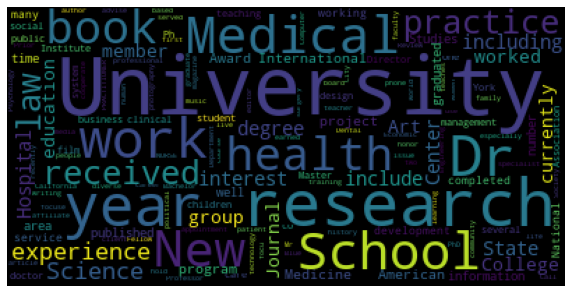

In [42]:
from wordcloud import WordCloud
all_descr = " ".join(train_df.description.values)
wordcloud_word = WordCloud(background_color="black", collocations=False).generate_from_text(all_descr)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

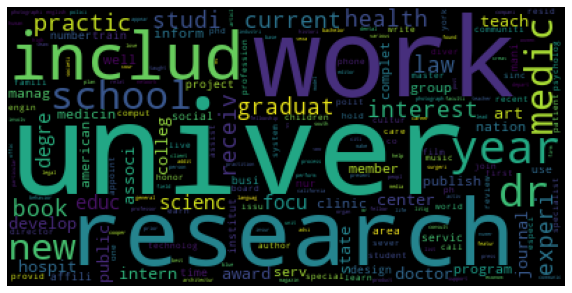

In [43]:
all_descr_clean_stem = " ".join(train_df.description_cleaned.values)
wordcloud_word = WordCloud(background_color="black", collocations=False).generate_from_text(all_descr_clean_stem)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

# Vectorization

We use TfidfVectorizer to transform words from text to numerical vector data.  

More vectorize are available on scikit-learn -> https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text

You also may want to have a look at words embedding methods (Word2vec, Glove, etc..)

**Test de la méthode TfIDF**

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
transformer = TfidfVectorizer().fit(train_df["description_cleaned"].values)
print("NB features: %d" %(len(transformer.vocabulary_)))
X_train = transformer.transform(train_df["description_cleaned"].values)
X_test = transformer.transform(test_df["description_cleaned"].values)
X_train

NB features: 175818


<217197x175818 sparse matrix of type '<class 'numpy.float64'>'
	with 6838325 stored elements in Compressed Sparse Row format>

# Learning
 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
start = time.time()
Y_train = train_label.Category.values
model = LinearSVC()
param_dist = {'penalty': ['l1', 'l2'],
              'loss': ['hinge', 'squared_hinge'],
              'C': [1.0, 2.0, 3.0, 4.0],
              'class_weight': ['balanced']}
cv_rf = GridSearchCV(model, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv=cv_rf.fit(X_train, Y_train)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

# Prediction

In [ ]:
predictions = cv.predict(X_test)
predictions

# File Generation

In [ ]:
test_df["Category"] = predictions
baseline_file = test_df[["Id","Category"]]
baseline_file.to_csv("baseline3.csv", index=False)

In [ ]:
baseline_file.head(5)